# EXEMPLO - Aula_23: Matriz de Custo e Curva de Lucro

Base de Dados <br>
Fonte da dados: kaglgle <br>
Link: https://www.kaggle.com/kost13/us-income-logistic-regression/data <br>
Resumo: Dados do Censo Americano referentes a renda dos cidadãos e variáveis explicativas como Idade, Educação, raça, etc. <br>
Objetivo: Ajustar um modelo de regressão logística para prever a renda do cidadão (<=50k-0 e >50k-1), em uma base de treinamento, para uma resposta binária, fazer a previsão desta resposta e avaliar a qualidade de ajuste do modelo em uma base de teste.


## 1. Importando os Dados

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

columns = ['Age','Workclass','fnlgwt','Education','Education num','Marital Status',
           'Occupation','Relationship','Race','Sex','Capital Gain','Capital Loss',
           'Hours/Week','Native country','Income']

train = pd.read_csv('C:/Users/crrodr/Desktop/Tera - Data Science/Bases para exemplos-exercicios/Aula_23-Matriz_Custo-Curva_Lucro/Adult_exemplo/adult-training.csv', names=columns)
test = pd.read_csv('C:/Users/crrodr/Desktop/Tera - Data Science/Bases para exemplos-exercicios/Aula_23-Matriz_Custo-Curva_Lucro/Adult_exemplo/adult-test.csv', names=columns, skiprows=1)

%matplotlib inline

In [2]:
# train.head()

In [3]:
train.shape

(32561, 15)

Mais informação sobre este data set pode se encontrada em: [archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names)

In [4]:
# train.dtypes

In [5]:
# test.dtypes

## 2. Limpando os dados
Algumas celulas contem ' ?' -> vamos converter para nan

In [6]:
train.replace(' ?', np.nan, inplace=True)
test.replace(' ?', np.nan, inplace=True)

In [7]:
# verificando quantidade de missing para cada var
train.isnull().sum()

Age                  0
Workclass         1836
fnlgwt               0
Education            0
Education num        0
Marital Status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital Gain         0
Capital Loss         0
Hours/Week           0
Native country     583
Income               0
dtype: int64

In [8]:
test.isnull().sum()

Age                 0
Workclass         963
fnlgwt              0
Education           0
Education num       0
Marital Status      0
Occupation        966
Relationship        0
Race                0
Sex                 0
Capital Gain        0
Capital Loss        0
Hours/Week          0
Native country    274
Income              0
dtype: int64

Como visto, somente Workclass, Occupation e Native country tem valores missing

# 3: Transformando as Variáveis Input

### 3.1 Income

Transformando a variável Income-Renda em 0's and 1's

In [9]:
# apply: aplica uma fç a coluna especificada - no caso Income
# defini a fç lambda (nome de variável restrita do python) e já aplica ela
train['Income'] = train['Income'].apply(lambda x: 1 if x==' >50K' else 0)
test['Income'] = test['Income'].apply(lambda x: 1 if x==' >50K.' else 0)

### 3.2 Age

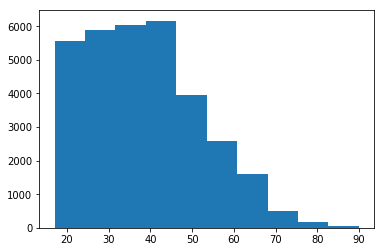

In [10]:
plt.hist(train['Age']);

A variável Age parece assimétrica, ela pode ser normalizada. 

### 3.3 Workclass

Tem muitas linhas missing, então vamos colocá-las em uma nova classe, substituindo por 0 e ver como fica o gráfico

In [11]:
train['Workclass'].fillna(' 0', inplace=True)
test['Workclass'].fillna(' 0', inplace=True)

In [12]:
train['Workclass'].value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 0                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64

As categorias Never-worked e Without-pay tem poucas obs então vamos juntá-las

In [13]:
train['Workclass'].replace(' Without-pay', ' Never-worked', inplace=True)
test['Workclass'].replace(' Without-pay', ' Never-worked', inplace=True)

### 3.4 fnlgwt

In [14]:
train['fnlgwt'].describe()

count    3.256100e+04
mean     1.897784e+05
std      1.055500e+05
min      1.228500e+04
25%      1.178270e+05
50%      1.783560e+05
75%      2.370510e+05
max      1.484705e+06
Name: fnlgwt, dtype: float64

A variável Fnlwgt tem números elevados e grande desvio padrão, vamos tomar um logaritmo dela

In [15]:
# poderia usar tb train['fnlgwt'] = train['fnlgwt'].apply(np.log1p)
train['fnlgwt'] = train['fnlgwt'].apply(lambda x: np.log1p(x))
test['fnlgwt'] = test['fnlgwt'].apply(lambda x: np.log1p(x))

In [16]:
train['fnlgwt'].describe()

count    32561.000000
mean        11.983778
std          0.630738
min          9.416216
25%         11.676981
50%         12.091542
75%         12.376035
max         14.210727
Name: fnlgwt, dtype: float64

### 3.5 Education

A educação primária é dividada em grades:' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th', ' 10th', ' 11th', ' 12th'. <br>
Por isso vamos juntar essas classes em uma nova classe - Primary

In [17]:
def primary(x):
    if x in [' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th', ' 10th', ' 11th', ' 12th']:
        return ' Primary'
    else:
        return x

In [18]:
train['Education'] = train['Education'].apply(primary)
test['Education'] = test['Education'].apply(primary)

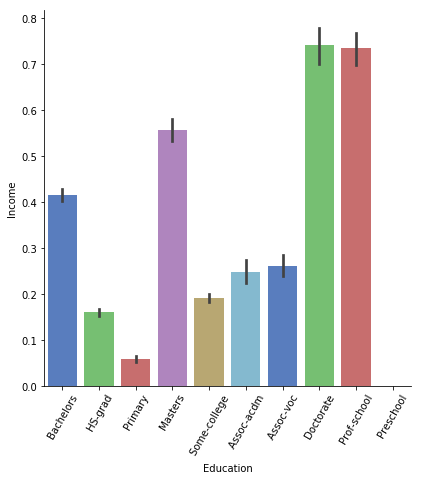

In [19]:
sns.factorplot(x="Education",y="Income",data=train,kind="bar", size = 6, 
palette = "muted")
plt.xticks(rotation=60);

### 3.6 Marital Status

In [20]:
train['Marital Status'].value_counts()

 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: Marital Status, dtype: int64

Há poucas obs na categoria Married-AF-spouse. Então vamos juntá-la com a categoria Married-civ-spouse.

In [21]:
train['Marital Status'].replace(' Married-AF-spouse', ' Married-civ-spouse', inplace=True)
test['Marital Status'].replace(' Married-AF-spouse', ' Married-civ-spouse', inplace=True)

### 3.7 Occupation

Tem muitas linhas missing, então vamos colocá-las em uma nova classe, substituindo por 0 e ver como fica o gráfico

In [22]:
train['Occupation'].fillna(' 0', inplace=True)
test['Occupation'].fillna(' 0', inplace=True)

In [23]:
train['Occupation'].value_counts()

 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 0                    1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: Occupation, dtype: int64

A categoria Armed-Forces tem poucas observações, então vamos juntá-la com a categoria 0

In [24]:
train['Occupation'].replace(' Armed-Forces', ' 0', inplace=True)
test['Occupation'].replace(' Armed-Forces', ' 0', inplace=True)

### 3.8 Native country 

Tem algumas linhas missing, então vamos colocá-las em uma nova classe, substituindo por 0 e ver como fica o gráfico

In [25]:
train['Native country'].fillna(' 0', inplace=True)
test['Native country'].fillna(' 0', inplace=True)

Vamos agrupar essas categorias.

In [26]:
def native(country):
    if country in [' United-States', ' Cuba', ' 0']:
        return 'US'
    elif country in [' England', ' Germany', ' Canada', ' Italy', ' France', ' Greece', ' Philippines']:
        return 'Western'
    elif country in [' Mexico', ' Puerto-Rico', ' Honduras', ' Jamaica', ' Columbia', ' Laos', ' Portugal', ' Haiti',
                     ' Dominican-Republic', ' El-Salvador', ' Guatemala', ' Peru', 
                     ' Trinadad&Tobago', ' Outlying-US(Guam-USVI-etc)', ' Nicaragua', ' Vietnam', ' Holand-Netherlands' ]:
        return 'Poor' 
    elif country in [' India', ' Iran', ' Cambodia', ' Taiwan', ' Japan', ' Yugoslavia', ' China', ' Hong']:
        return 'Eastern'
    elif country in [' South', ' Poland', ' Ireland', ' Hungary', ' Scotland', ' Thailand', ' Ecuador']:
        return 'Poland team'
    
    else: 
        return country    

In [27]:
train['Native country'] = train['Native country'].apply(native)
test['Native country'] = test['Native country'].apply(native)

In [28]:
train['Native country'].value_counts()

US             29848
Poor            1415
Western          677
Eastern          386
Poland team      235
Name: Native country, dtype: int64

### 3.9 Criando Dummys para as variáveis categóricas

Agora precisamos criar dummys para as variáveis categóricas usando o pd.get_dummies(). <br>
Como esse método pode causar alguns problemas, mesclarmos os conjuntos de dados. Isso garante que as dimensões para ambos os conjuntos de dados sejam iguais às dos conjuntos de dados de treinamento e teste.

In [29]:
#merge datasets
joint = pd.concat([train, test], axis=0)
# Renaming certain columns for better readability
joint = joint.rename(columns={'Education num': 'Education_num', 'Marital Status': 'Marital', 'Capital Gain': 'Capital_Gain',
                              'Capital Loss': 'Capital_Loss',   'Hours/Week': 'Hours_Week',  'Native country': 'Country'
                                                })

In [30]:
#list of columns with dtype: object
#axes[1] coluna
#axes[0] linha
categorical_features = joint.select_dtypes(include=['object']).axes[1] # retorna as vars que são do tipo objeto

# unique: retorna os valores únicos
# nunique: retorna o número de valores únicos
for col in categorical_features:
    print (col, joint[col].nunique()) # retorna as vars que são do tipo objeto e a quantidade de categorias em cada uma delas

Workclass 8
Education 10
Marital 6
Occupation 14
Relationship 6
Race 5
Sex 2
Country 5


In [31]:
#criando dummys para as variáveis categoricas
for col in categorical_features:
    joint = pd.concat([joint, pd.get_dummies(joint[col], prefix=col, prefix_sep='_')], axis=1)
    joint.drop(col, axis=1, inplace=True)

In [32]:
# renomeando as variáveis
new_columns = {}
for i in joint.columns:
    new_column = i.replace(" ", "")
    new_column = new_column.replace("-", "_")
    new_columns[i] = new_column

joint = joint.rename(columns=new_columns)

Separando novamente a base em treinamento e teste.

In [33]:
train = joint.head(train.shape[0])
test = joint.tail(test.shape[0])

Dividindo o data frame em inputs e target

In [34]:
Xtrain = train.drop('Income', axis=1)
Ttrain = train['Income']

Xtest = test.drop('Income', axis=1)
Ttest = test['Income']


## 4: Ajustando um modelo de Regressão Logística usando sklearn

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
import pylab as pl



C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [36]:
model = LogisticRegression()
# ajustando o modelo
model.fit(Xtrain, Ttrain)
# previsão na base de teste
Ytest = model.predict(Xtest)


### 4.1 Calculando Matriz de Confusão, AUC, precision e recall para base de teste

In [37]:
cnf_matrix = confusion_matrix(Ttest, Ytest)
print ("\n\n ---Matriz de Confusão---")
print(cnf_matrix)

TN = cnf_matrix[0,0]
FP = cnf_matrix[0,1]
FN = cnf_matrix[1,0]
TP = cnf_matrix[1,1]
acuracia = (TN+TP)/(TN+FP+FN+TP)
missclassification = 1-acuracia
print ("Acuracia = %2.6f" % acuracia)
print ("missclassification = %2.6f" % missclassification)

print ("\n\n ---Logistic Model---")
logit_roc_auc = roc_auc_score(Ttest, model.predict(Xtest))
print ("Logistic AUC = %2.6f" % logit_roc_auc)
print(classification_report(Ttest, Ytest))



 ---Matriz de Confusão---
[[11574   861]
 [ 1572  2274]]
Acuracia = 0.850562
missclassification = 0.149438


 ---Logistic Model---
Logistic AUC = 0.761012
             precision    recall  f1-score   support

          0       0.88      0.93      0.90     12435
          1       0.73      0.59      0.65      3846

avg / total       0.84      0.85      0.85     16281



### 4.2 Plotando a curva ROC para cada possível ponto de corte

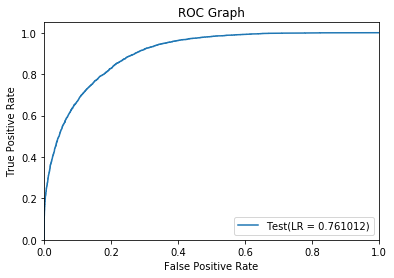

In [38]:
# Plotando o curva ROC para a base de teste
fpr, tpr, thresholds = roc_curve(Ttest, model.predict_proba(Xtest)[:,1])
plt.plot(fpr, tpr, label='Test(LR = %0.6f)' % logit_roc_auc)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

## 5. Matriz de Custo e Curva de Lucro

### 5.1 Entendendo o uso da matriz de custo

A ideia do modelo é prever se a pessoa tem renda <=50k(0) ou renda >50K(1) e que varíáveis influenciam nesta renda. <br>
Para as pessoas previstas com renda >50K (previstas como 1) vamos oferecer um produto específico para esse publico de alta renda. <br>
O custo da campanha de marketing para oferecer esse produto para o cliente é 100 reais, mas se o cliente compra o produto ganhamos 500 reais. <br>
Com essas informações conseguimos definir a matriz de custo/benefício

In [39]:
# Matriz de Custo
'''Cost of FP: 1, cost of FN: 2, cost of TN: 0, cost of TP: -1'''
cost_TP = 400; cost_FP = -100; cost_FN = 0; cost_TN = 0;
cb_matrix = np.array([[cost_TN, cost_FP],[cost_FN, cost_TP]])
cb_matrix

array([[   0, -100],
       [   0,  400]])

### 5.2 Calculando o lucro

In [40]:
# Calcula a probabilidade para a base de teste
predict_prob = model.predict_proba(Xtest)[:,1]
# Cria um data frame com a probabilidade predita e a y_real
df = pd.DataFrame( {"predict_prob":predict_prob, "true_value":Ttest} )
# Ordena o data frame df pela prob predita
df.sort_values(by="predict_prob", inplace=True)

In [41]:
# Defini um ponto de corte para o cálculo do lucro
p = 0.5
label_p = df.predict_prob >= p    
counf = confusion_matrix(df.true_value, label_p)
lucro = (counf * cb_matrix).sum()
print(lucro)

823500


In [42]:
# e se eu definir outro ponto de corte
p = 0.22
label_p = df.predict_prob >= p    
counf = confusion_matrix(df.true_value, label_p)
lucro = (counf * cb_matrix).sum()
print(lucro)

1042100


### 5.3 Como podemos fazer para encontrar o ponto de corte ótimo, ou seja, o que retorno o maior lucro

In [43]:
#Calcula o lucro para "cada" ponto de corte 
predict_prob = model.predict_proba(Xtest)[:,1]
df = pd.DataFrame( {"predict_prob":predict_prob, "true_value":Ttest} )
df.sort_values(by="predict_prob", inplace=True)

def profit_gain(predict_prob, true_value, p_step):
    lucro = []
    p=[0]
    while p[-1]+p_step<1:
        label_p = (df.predict_prob >= p[-1]).astype(int)    
        counf = confusion_matrix(df.true_value, label_p)
        lucro.append( (counf * cb_matrix).sum() )
        p.append(p[-1]+p_step)
    return lucro, p

In [44]:
array_lucro, p = profit_gain(df.predict_prob, df.true_value, 0.1 )

In [45]:
print(array_lucro)
print(p)

[294900, 1001300, 1044400, 996100, 924300, 823500, 708400, 549400, 368700, 233300]
[0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7, 0.7999999999999999, 0.8999999999999999, 0.9999999999999999]


## 6. Agora vamos tornar o processo mais automatico

### 6.1 Vamos ajustar alguns modelos para classificação

In [46]:
# Carregando pacotes necessários para ajustar os modelos
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import GradientBoostingClassifier as GBC

In [47]:
# ajustando vários modelos para comparar qual o melhor: usando curva de lucro e curva ROC
model_1 = LR()
model_1.fit(Xtrain, Ttrain)

model_2 = RF()
model_2.fit(Xtrain, Ttrain)

model_3 = GBC()
model_3.fit(Xtrain, Ttrain)

models = model_1, model_2, model_3

### 6.2 Definir funções para: 
- Calcular o lucro em cada ponto de corte 
- Plotar a curva de lucro versus o ponto de corte ótimo

In [48]:
#Calcula o lucro para "cada" ponto de corte e depois plota o lucro versus a probabilidade
# models: lista com os modelos a serem comparados
# X: Base de teste só com as variáveis input
# y_true=true_value: Base de teste só com a variável target
# p_step: tamanho do passo para calcular o lucro - ponto de corte
# predict_prob: probabilidade predita para a base X_test - comando predict_proba
def profit_gain(predict_prob, true_value, p_step):
    df = pd.DataFrame( {"predict_prob":predict_prob, "true_value":true_value} )
    df.sort_values(by="predict_prob", inplace=True)
    lucro = []
    p=[0]
    while p[-1]<=1:
        label_p = (df.predict_prob >= p[-1]).astype(int)    
        counf = confusion_matrix(df.true_value, label_p)
        lucro.append( (counf * cb_matrix).sum() )
        p.append(p[-1]+p_step)
    return lucro, p

def plot_profit( predict_prob, true_value, p_step ):
    array_lucro, p = profit_gain( predict_prob, true_value, p_step )
    plt.plot(p[:-1], array_lucro)
    return None

def multi_plot( models, X, y_true, p_step):
    for i in models:
        predict_prob = i.predict_proba( X )[:,1]
        plot_profit( predict_prob, y_true, p_step )
    plt.legend([i.__class__.__name__ for i in models])
    plt.show()

### 6.3 PLotar a curva de lucro para os modelos ajustados

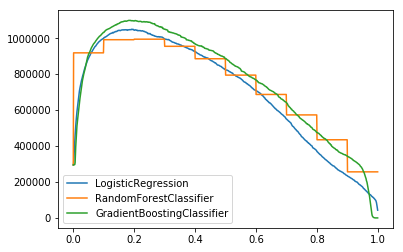

In [49]:
# models: lista com os modelos a serem comparados
# X: Base de teste só com as variáveis input
# y_true: Base de teste só com a variável target
# p_step: tamanho do passo para calcular o lucro - ponto de corte
multi_plot( models=models, X=Xtest, y_true=Ttest, p_step=0.001)

### 6.4 PLotar a curva ROC para os modelos ajustados

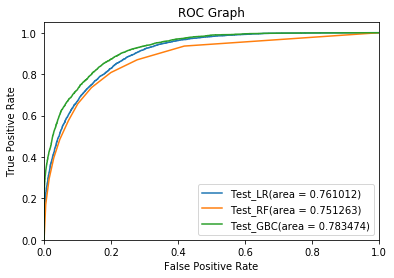

In [50]:
# Plotando curva ROC para todos os modelos
# fpr1: sensibilidade - comando roc_curve
# tpr1: 1- especificidade - comando roc_curve
fpr1, tpr1, thresholds1 = roc_curve(Ttest, model_1.predict_proba(Xtest)[:,1])
# calculando a área abaixo da curva roc - comando roc_auc_score
logit_roc_auc1 = roc_auc_score(Ttest, model_1.predict(Xtest))
# plotando a sensibilidade versus (1-especificidade)
# coloco como legenda o valor calculado em logit_roc_auc1
plt.plot(fpr1, tpr1, label='Test_LR(area = %0.6f)' % logit_roc_auc1)
#
fpr2, tpr2, thresholds2 = roc_curve(Ttest, model_2.predict_proba(Xtest)[:,1])
logit_roc_auc2 = roc_auc_score(Ttest, model_2.predict(Xtest))
plt.plot(fpr2, tpr2, label='Test_RF(area = %0.6f)' % logit_roc_auc2)
#
fpr3, tpr3, thresholds3 = roc_curve(Ttest, model_3.predict_proba(Xtest)[:,1])
logit_roc_auc3 = roc_auc_score(Ttest, model_3.predict(Xtest))
plt.plot(fpr3, tpr3, label='Test_GBC(area = %0.6f)' % logit_roc_auc3)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

Referências <br>
- https://www.kaggle.com/kost13/us-income-logistic-regression
- http://planspace.org/20150423-forward_selection_with_statsmodels/